COUNTS:  {'0 1 0 1 0 1': 1}
Binary #:  1 0 1 0 1 0
Classical Register-A Measurements:  0 1 0 1
Classical Register-B Measurements:  0 1


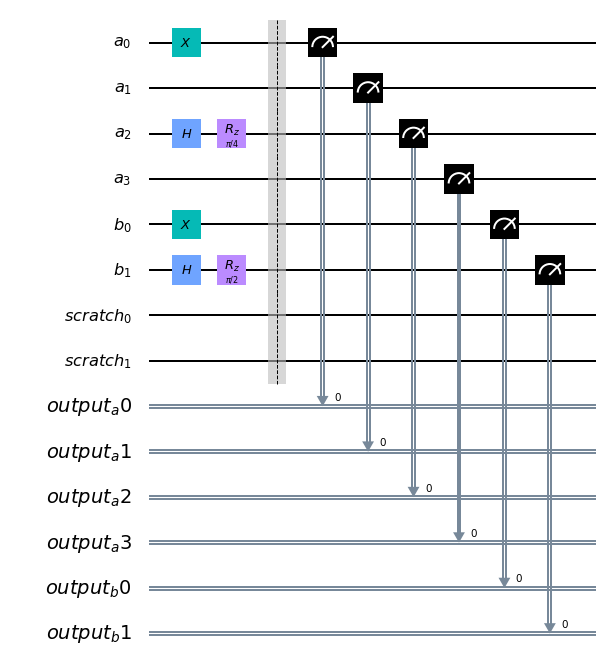

In [44]:
## Programming Quantum Computers
##   by Eric Johnston, Nic Harrigan and Mercedes Gimeno-Segovia
##   O'Reilly Media
##
## More samples like this can be found at http://oreilly-qc.github.io
##
## A complete notebook of all Chapter 5 samples (including this one) can be found at
##  https://github.com/oreilly-qc/oreilly-qc.github.io/tree/master/samples/Qiskit

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ, BasicAer
import math
## Uncomment the next line to see diagrams when running in a notebook
#%matplotlib inline

## Example 5-2: Adding Two Quantum Integers

## Note that this looks different from the gates in the book, because
## we're building the operations from Toffoli gates

# Set up the program
a = QuantumRegister(4, name='a')
b = QuantumRegister(2, name='b')
scratch = QuantumRegister(2, name='scratch')


# Setup SIX Classical Registers
output_a0 = ClassicalRegister(1, name='output_a0')
output_a1 = ClassicalRegister(1, name='output_a1')
output_a2 = ClassicalRegister(1, name='output_a2')
output_a3 = ClassicalRegister(1, name='output_a3')
output_b0 = ClassicalRegister(1, name='output_b0')
output_b1 = ClassicalRegister(1, name='output_b1')

# Set up Quantum Circuit
# qc = QuantumCircuit(a, b, scratch)
qc = QuantumCircuit(a, b, scratch, output_a0, output_a1, output_a2, output_a3, output_b0, output_b1)


def main():
    ## initialization
    qc.x(a[0])
    qc.h(a[2])
    qc.rz(math.radians(45), a[2])
    qc.x(b[0])
    qc.h(b[1])
    qc.rz(math.radians(90), b[1])
    qc.barrier()
    
    ## Increment
    # add_qint(a, b)

###############################################
## Some utility functions

def add_qint(qdest, rhs):
    for bit in range(len(rhs)):
        add_int(qdest, 1 << bit, [rhs[bit]])


def add_int(qdest, rhs, condition_qubits=None):
    if condition_qubits is None:
        condition_qubits = []
    reverse_to_subtract = False
    if rhs == 0:
        return
    elif rhs < 0:
        rhs = -rhs
        reverse_to_subtract = True
    ops = []
    add_val = int(rhs)
    condition_mask = (1 << len(qdest)) - 1

    add_val_mask = 1
    while add_val_mask <= add_val:
        cmask = condition_mask & ~(add_val_mask - 1)
        if add_val_mask & add_val:
            add_shift_mask = 1 << (len(qdest) - 1)
            while add_shift_mask >= add_val_mask:
                cmask &= ~add_shift_mask
                ops.append((add_shift_mask, cmask))
                add_shift_mask >>= 1
        condition_mask &= ~add_val_mask
        add_val_mask <<= 1
    if reverse_to_subtract:
        ops.reverse()
    for inst in ops:
        op_qubits = [x for x in condition_qubits]
        mask = 1
        for i in range(len(qdest)):
            if inst[1] & (1 << i):
                op_qubits.append(qdest[i])
        for i in range(len(qdest)):
            if inst[0] & (1 << i):
                op_qubits.append(qdest[i])
        multi_cx(op_qubits)

def multi_cz(qubits):
    ## This will perform a CCCCCZ on as many qubits as we want,
    ## as long as we have enough scratch qubits
    multi_cx(qubits, do_cz=True)

def multi_cx(qubits, do_cz=False):
    ## This will perform a CCCCCX with as many conditions as we want,
    ## as long as we have enough scratch qubits
    ## The last qubit in the list is the target.
    target = qubits[-1]
    conds = qubits[:-1]
    scratch_index = 0
    ops = []
    while len(conds) > 2:
        new_conds = []
        for i in range(len(conds)//2):
            ops.append((conds[i * 2], conds[i * 2 + 1], scratch[scratch_index]))
            new_conds.append(scratch[scratch_index])
            scratch_index += 1
        if len(conds) & 1:
            new_conds.append(conds[-1])
        conds = new_conds
    for op in ops:
        qc.ccx(op[0], op[1], op[2])
    if do_cz:
        qc.h(target)
    if len(conds) == 0:
        qc.x(target)
    elif len(conds) == 1:
        qc.cx(conds[0], target)
    else:
        qc.ccx(conds[0], conds[1], target)
    if do_cz:
        qc.h(target)
    ops.reverse()
    for op in ops:
        qc.ccx(op[0], op[1], op[2])

main()


# Measure the Qubits from quantum register 'a' into classical registers (0-3)
qc.measure(a[0], output_a0)
qc.measure(a[1], output_a1)
qc.measure(a[2], output_a2)
qc.measure(a[3], output_a3)


qc.measure(b[0], output_b0)
qc.measure(b[1], output_b1)


## That's the program. Everything below runs and draws it.

backend = BasicAer.get_backend('statevector_simulator')
job = execute(qc, backend)
result = job.result()

# Get the outputstate from the output vector

outputstate = result.get_statevector(qc, decimals=3)      
        
# Fetch the counts and print out the classical measurements in order (l->R) of each q-register (a & b)       

counts = result.get_counts(qc)
print("COUNTS: ", counts)

# Rearrange the counts in the order we need them
for k in counts:
    binary_number = ''.join(reversed(k))       
    
       
# Set up the binary numbers of each c-register (a & b)         
c_register_a = binary_number[0 : 7][::-1]
c_register_b = binary_number[8 : 11][::-1] 
    
print("Binary #: ", binary_number)    
    
print("Classical Register-A Measurements: ", c_register_a)     
print("Classical Register-B Measurements: ", c_register_b)  
    
qc.draw(output='mpl')        # draw the circuit

